# Conformal Prediction Pipeline

This notebook trains recommenders on three datasets (MovieLens, MS LETOR, Yahoo LETOR), saves predictions/metrics, and runs conformal prediction (CP) evaluation.

## Data overview
- **MovieLens**: user–item ratings (labels 1–5). Files: tab-separated `user_id, item_id, rating, timestamp`. No `qid`; we treat `user_id` as `qid` in outputs.
- **MS LETOR**: query–doc LETOR text, lines like `label qid:<id> feat:val ...`, labels 0–4. Densified to 136 features.
- **Yahoo LETOR**: same LETOR format, labels 0–4, densified to 699 features.
- **Unified model output for CP**: `qid, doc_id, label, pred_score` (pred_score is sigmoid-scaled to ~[0,1]).

## Steps to run
1. Configure dataset paths/CP knobs in `DATASETS`.
2. Run the training cell: trains per-dataset model (MF for MovieLens; MLP scorer for LETOR) and saves `*_predictions.csv` / `*_metrics.csv` under `recommender_outputs/`.
3. Run the CP cell: loads predictions (from memory or CSV), runs `run_repeated_cp`, saves `*_cp.json`.
4. Run the plotting cell to view FDP/selected-size histograms for all successful datasets.

## Functions and data flow
- **Loading & splits**
  - MovieLens: `run_movielens_from_txt` reads txt splits (train/valid/test from `data/movie`), built from ~60/20/20 ratio; builds user/item encoders across splits.
  - LETOR (MS/Yahoo): `run_letor_from_txt` parses LETOR text into dense matrices (feature_dim 136/699), uses provided train/valid/test files (`data/ms`, `data/yahoo`, ratios ~63/20/21 and ~65/10/23 respectively), fits a StandardScaler on train, applies to val/test.
- **Model training & tuning**
  - MovieLens: matrix factorization with grid search over the provided `search_space` (defaults in code), early stopping on val RMSE; outputs test predictions + RMSE/MAE.
  - LETOR: MLP scorer (`models/mlp_scorer`) trained with MSE; hyperparams from `LetorConfig`; early stopping on val RMSE; outputs test predictions + RMSE/MAE.
  - Both apply sigmoid to raw scores before saving `pred_score`.
- **CP pipeline**
  - `run_repeated_cp`: converts predictions to query dict, repeatedly splits queries into calibration/test (`test_ratio`, default 0.5), searches λ on calibration via `_search_lambda` (grid down from 0.99 by `lambda_step`, default 0.001), computes FDP on test with `label_threshold` (default 3 unless overridden), repeats `n_runs` with different seeds, aggregates mean FDP/size and success probability `P(FDP<=alpha)`.
  - `print_cp_summary`: prints α, δ, empirical success, mean FDP and set size.
  - `plot_cp_hist`: histograms of FDP and selected-set size over runs.


In [9]:
from pathlib import Path
import json
import pandas as pd

from models.PR_model_ml import run_movielens_from_txt
from models.PR_model_lector import run_letor_from_txt, LetorConfig
from cp_pipeline import run_repeated_cp, plot_cp_hist, print_cp_summary, load_predictions

## 0. Configuration

In [10]:
# Dataset configuration (adjust CP knobs per dataset in cp_args)
recs_dir = Path("recommender_outputs")
recs_dir.mkdir(exist_ok=True)

DATASETS = {
    "movie": {
        "kind": "movielens",
        "paths": {
            "train": Path("data/movie/train.txt"),
            "valid": Path("data/movie/valid.txt"),
            "test": Path("data/movie/test.txt"),
        },
        "cp_args": {
            "alpha": 0.3,
            "delta": 0.1,
            "n_runs": 100,
            "lambda_step": 0.01,
            "label_threshold": 3,
            "test_ratio": 0.5,
            "seed": 123,
        },
    },
    "ms": {
        "kind": "letor",
        "feature_dim": 136,
        "paths": {
            "train": Path("data/ms/train.txt"),
            "valid": Path("data/ms/valid.txt"),
            "test": Path("data/ms/test.txt"),
        },
        "letor_cfg": LetorConfig(hidden=[256, 128], dropout=0.1, epochs=20, batch_size=512),
        "cp_args": {
            "alpha": 0.3,
            "delta": 0.1,
            "n_runs": 100,
            "lambda_step": 0.01,
            "label_threshold": 3,
            "test_ratio": 0.5,
            "seed": 123,
        },
    },
    "yahoo": {
        "kind": "letor",
        "feature_dim": 699,
        "paths": {
            "train": Path("data/yahoo/train.txt"),
            "valid": Path("data/yahoo/valid.txt"),
            "test": Path("data/yahoo/test.txt"),
        },
        "letor_cfg": LetorConfig(hidden=[512, 256], dropout=0.1, epochs=20, batch_size=512),
        "cp_args": {
            "alpha": 0.3,
            "delta": 0.1,
            "n_runs": 100,
            "lambda_step": 0.01,
            "label_threshold": 3,
            "test_ratio": 0.5,
            "seed": 123,
        },
    },
}


In [11]:
# Ensure MovieLens splits exist (download/split if missing)
from utils.data_loader import split_movielens_to_txt

movie_paths = DATASETS.get("movie", {}).get("paths")
if movie_paths:
    movie_dir = movie_paths["train"].parent
    if not all(p.exists() for p in movie_paths.values()):
        print("MovieLens splits not found; generating them (download=True)...")
        split_movielens_to_txt(data_root=movie_dir, download=True)
    else:
        print("MovieLens splits already present.")


MovieLens splits already present.


## 1. Train, Validate and Test Recommender Model 

In [5]:
# Part 1: Train and produce prediction files (sigmoid applied to model scores)
predictions = {}

for name, cfg in DATASETS.items():
    pred_path = recs_dir / f"{name}_predictions.csv"
    metrics_path = recs_dir / f"{name}_metrics.csv"

    try:
        if cfg["kind"] == "movielens":
            df_pred = run_movielens_from_txt(
                cfg["paths"]["train"],
                cfg["paths"]["valid"],
                cfg["paths"]["test"],
                output_csv=pred_path,
                metrics_path=metrics_path,
                apply_sigmoid=True,
            )
        else:
            df_pred = run_letor_from_txt(
                cfg["paths"]["train"],
                cfg["paths"]["valid"],
                cfg["paths"]["test"],
                feature_dim=cfg["feature_dim"],
                cfg=cfg.get("letor_cfg", LetorConfig()),
                output_csv=pred_path,
                metrics_path=metrics_path,
                apply_sigmoid=True,
            )
        predictions[name] = df_pred
        print(f"[TRAIN] {name}: saved predictions to {pred_path} and metrics to {metrics_path}")
    except Exception as exc:  # noqa: BLE001
        predictions[name] = exc
        print(f"[TRAIN][ERROR] {name}: {exc}")


Best config: MFConfig(embedding_dim=32, lr=0.005, weight_decay=1e-05, epochs=20, batch_size=1024, patience=3)  |  val RMSE=4.7725
[TRAIN] movie: saved predictions to recommender_outputs/movie_predictions.csv and metrics to recommender_outputs/movie_metrics.csv
[TRAIN] ms: saved predictions to recommender_outputs/ms_predictions.csv and metrics to recommender_outputs/ms_metrics.csv
[TRAIN] yahoo: saved predictions to recommender_outputs/yahoo_predictions.csv and metrics to recommender_outputs/yahoo_metrics.csv


## 2. Conformal Prediction 

In [12]:
# Part 2: Conformal prediction on saved outputs (all knobs per dataset)
results = {}
try:
    predictions
except NameError:
    predictions = {}

for name, cfg in DATASETS.items():
    pred_path = recs_dir / f"{name}_predictions.csv"

    if isinstance(predictions.get(name), Exception):
        print(f"[CP][SKIP] {name}: training failed, skipping CP.")
        results[name] = {"error": str(predictions[name])}
        continue

    if not pred_path.exists():
        msg = f"prediction file not found at {pred_path}; run training or place the CSV."
        print(f"[CP][ERROR] {name}: {msg}")
        results[name] = {"error": msg}
        continue

    cp_cfg = cfg.get("cp_args", {})
    alpha = cp_cfg.get("alpha", 0.3)
    delta = cp_cfg.get("delta", 0.1)
    n_runs = cp_cfg.get("n_runs", 20)
    lambda_step = cp_cfg.get("lambda_step", 0.001)
    label_threshold = cp_cfg.get("label_threshold", 3)
    test_ratio = cp_cfg.get("test_ratio", 0.5)
    seed = cp_cfg.get("seed", 123)

    try:
        df_pred = load_predictions(pred_path)
        res = run_repeated_cp(
            df_pred,
            n_runs=n_runs,
            alpha=alpha,
            delta=delta,
            lambda_step=lambda_step,
            label_threshold=label_threshold,
            test_ratio=test_ratio,
            seed=seed,
        )
        cp_path = recs_dir / f"{name}_cp.json"
        cp_path.write_text(json.dumps(res, indent=2, default=float))
        results[name] = res
        print(
            f"=== CP SUMMARY: {name.upper()} "
            f"(α={alpha}, δ={delta}, step={lambda_step}, label_threshold={label_threshold}, test_ratio={test_ratio}, seed={seed}) ==="
        )
        print_cp_summary(res, alpha=alpha, delta=delta)
    except Exception as exc:  # noqa: BLE001
        results[name] = {"error": str(exc)}
        print(f"[CP][ERROR] {name}: {exc}")


[001/100]  λ̂=0.010   meanFDR=0.162
[020/100]  λ̂=0.010   meanFDR=0.162
[040/100]  λ̂=0.010   meanFDR=0.156
[060/100]  λ̂=0.010   meanFDR=0.162
[080/100]  λ̂=0.010   meanFDR=0.164
[100/100]  λ̂=0.010   meanFDR=0.165
=== CP SUMMARY: MOVIE (α=0.3, δ=0.1, step=0.01, label_threshold=3, test_ratio=0.5, seed=123) ===

================== Conformal FDR Summary ==================
α (target FDR):              0.3
δ (tolerance):               0.1
Target:                      P(FDR ≤ α) ≥ 1-δ = 0.900
Empirical:                   P̂ = 1.000
Mean FDR:                    0.163 ± 0.004
Mean set size:               58.83 ± 2.15
[001/100]  λ̂=0.820   meanFDR=0.202
[020/100]  λ̂=0.820   meanFDR=0.209
[040/100]  λ̂=0.820   meanFDR=0.210
[060/100]  λ̂=0.820   meanFDR=0.198
[080/100]  λ̂=0.820   meanFDR=0.206
[100/100]  λ̂=0.820   meanFDR=0.211
=== CP SUMMARY: MS (α=0.3, δ=0.1, step=0.01, label_threshold=3, test_ratio=0.5, seed=123) ===

================== Conformal FDR Summary ==================
α (target 

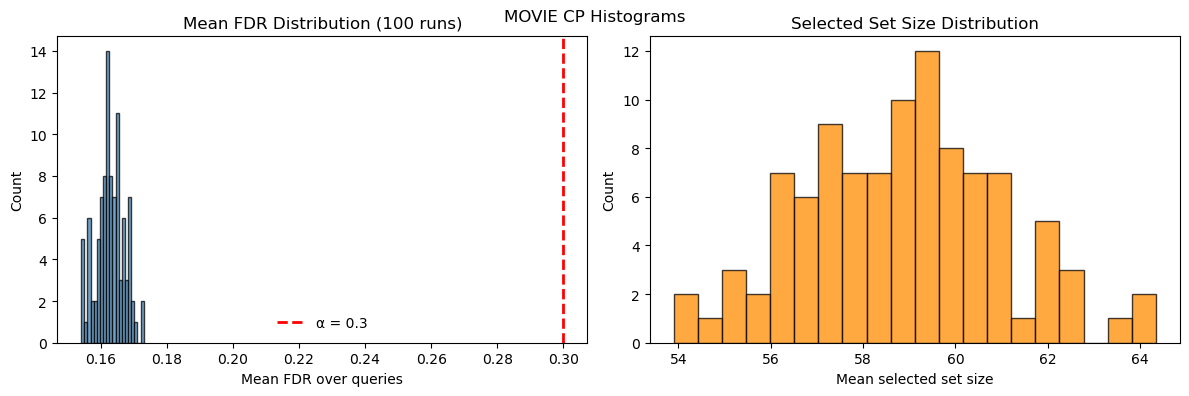

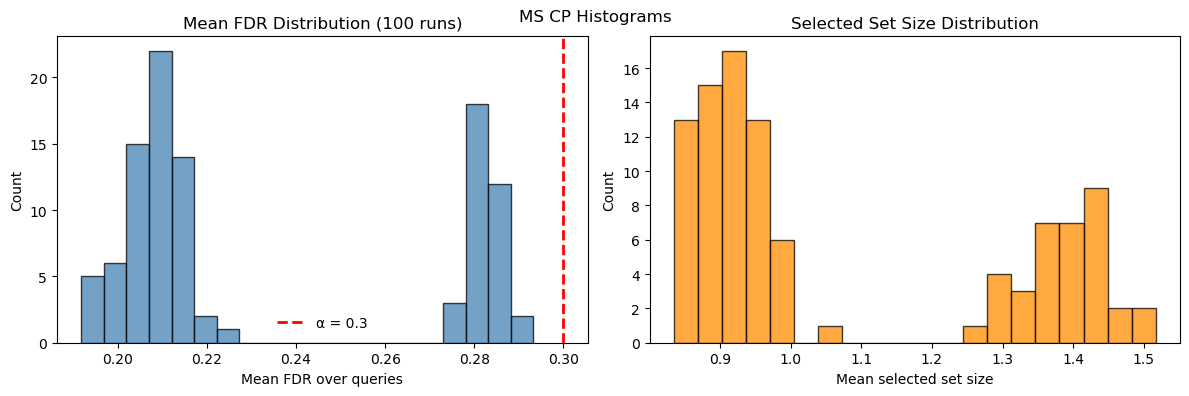

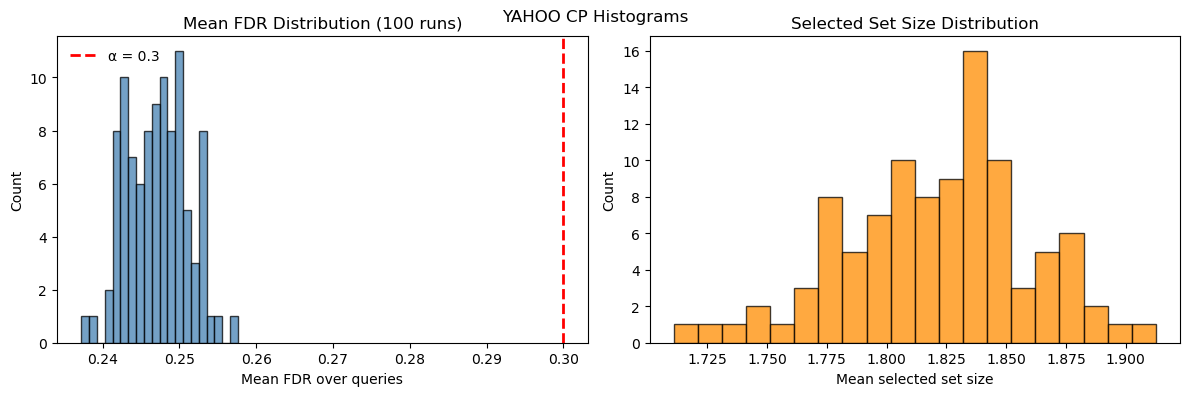

In [13]:
# Plot histograms for all successful datasets
success_ds = [k for k, v in results.items() if isinstance(v, dict) and "fdr_list" in v]
if success_ds:
    for key in success_ds:
        fig, axes = plot_cp_hist(results[key], alpha=DATASETS[key].get("cp_args", {}).get("alpha", 0.3))
        fig.suptitle(f"{key.upper()} CP Histograms")
else:
    print("No CP results available to plot.")
